Imagine a black box, or a mystery ML model, that takes two numbers as input and returns a log-likelihood score. Your goal is to maximise that score, but each output is noisy, and depending on where you start, you might get stuck in a local optimum. 

To tackle this, you use Bayesian optimisation, which selects the next inputs based on what it has learned so far. It balances exploration with exploitation, making it well suited to noisy outputs and complex functions with many local peaks.

import numpy as np
import pandas as pd

In [11]:
import numpy as np
import pandas as pd

In [12]:
inputs_f2 = np.load('function_2/initial_inputs.npy')
outputs_f2 = np.load('function_2/initial_outputs.npy')

In [13]:
print("Inputs (Function 2):", inputs_f2)

Inputs (Function 2): [[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]]


In [14]:
new_input_value_wk13 = np.array([0.828282, 0.989898])
inputs_f2 = np.vstack([inputs_f2, new_input_value_wk13])
print("Updated Inputs (Function 2):", inputs_f2)

Updated Inputs (Function 2): [[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [0.828282   0.989898  ]]


In [15]:
print("Ouputs (Function 2):", outputs_f2)

Ouputs (Function 2): [ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522]


In [16]:
new_output_value_wk13 = 0.08895869023933925
outputs_f2 = np.append(outputs_f2, new_output_value_wk13)
print("Updated Outputs (Function 2):", outputs_f2)

Updated Outputs (Function 2): [ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522  0.08895869]


Visualizing the points


Bright points → higher log-likelihood

Dark points → lower log-likelihood

Gives a sense of where peaks might be and the spread of inputs

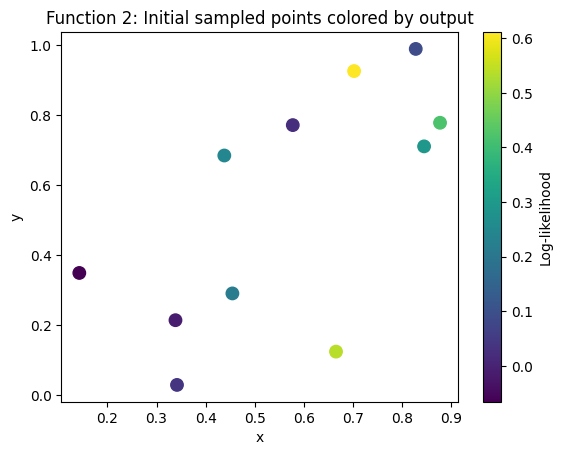

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.scatter(inputs_f2[:,0], inputs_f2[:,1], c=outputs_f2, s=80, cmap='viridis')
plt.colorbar(label="Log-likelihood")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Function 2: Initial sampled points colored by output")
plt.show()

Highlight the current best

This shows where the maximum observed log-likelihood is so far

BO will use this to decide between exploitation (near best) and exploration (uncertain regions)

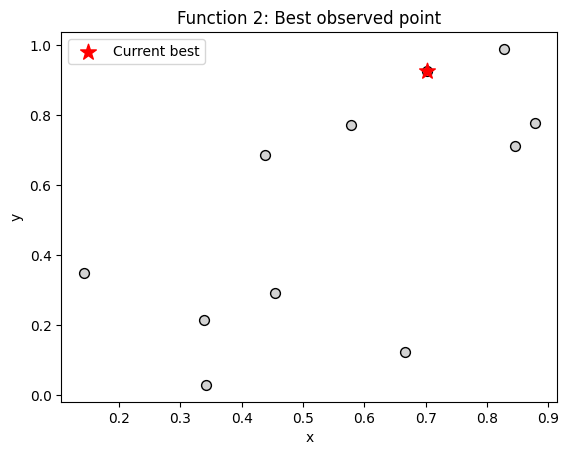

In [18]:
idx_best = np.argmax(outputs_f2)
x_best = inputs_f2[idx_best]

plt.figure()
plt.scatter(inputs_f2[:,0], inputs_f2[:,1], c='lightgray', s=50, edgecolors='black')
plt.scatter(x_best[0], x_best[1], c='red', s=140, marker='*', label='Current best')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Function 2: Best observed point")
plt.legend()
plt.show()

Fit the Gaussian process

RBF → smooth peaks

WhiteKernel → accounts for noisy outputs

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-2,1.0)) \
         + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6,1e-1))

In [20]:
gp_f2 = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=42
)

gp_f2.fit(inputs_f2, outputs_f2)
print("Optimized kernel:", gp_f2.kernel_)


Optimized kernel: 0.999**2 * RBF(length_scale=0.0565) + WhiteKernel(noise_level=1e-06)


/opt/homebrew/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Visualize the mean and uncertainity

In [21]:
grid_size = 100
x = np.linspace(0,1,grid_size)
y = np.linspace(0,1,grid_size)
Xg, Yg = np.meshgrid(x, y)
X_grid = np.column_stack([Xg.ravel(), Yg.ravel()])

mu, sigma = gp_f2.predict(X_grid, return_std=True)
mu = mu.reshape(grid_size, grid_size)
sigma = sigma.reshape(grid_size, grid_size)

Visualize the GP mean

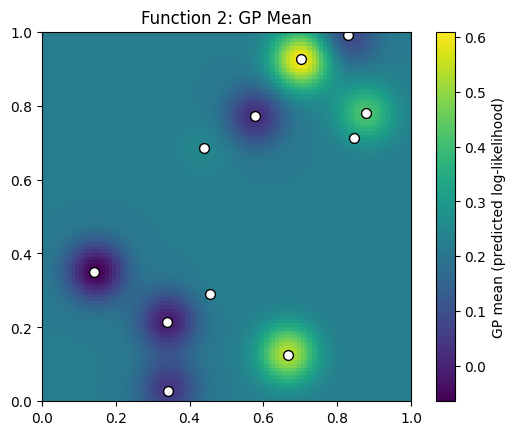

In [22]:
plt.figure()
plt.imshow(mu, origin='lower', extent=(0,1,0,1), aspect='equal', cmap='viridis')
plt.colorbar(label="GP mean (predicted log-likelihood)")
plt.scatter(inputs_f2[:,0], inputs_f2[:,1], c='white', s=50, edgecolors='black')
plt.title("Function 2: GP Mean")
plt.show()

Visualize the unceratinity

Bright regions → high uncertainty → BO wants to explore here

Dark regions → low uncertainty → already sampled

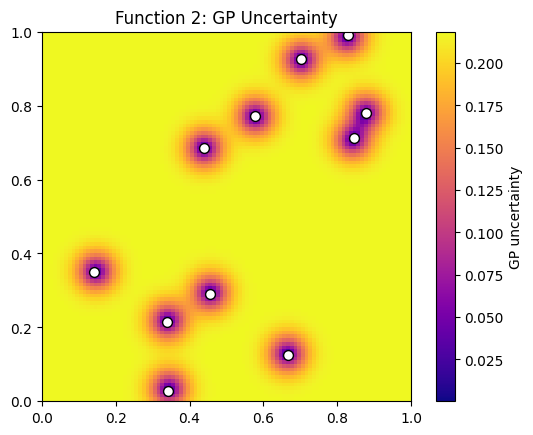

In [23]:
plt.figure()
plt.imshow(sigma, origin='lower', extent=(0,1,0,1), aspect='equal', cmap='plasma')
plt.colorbar(label="GP uncertainty")
plt.scatter(inputs_f2[:,0], inputs_f2[:,1], c='white', s=50, edgecolors='black')
plt.title("Function 2: GP Uncertainty")
plt.show()

In [26]:
kappa = 1.5
UCB = mu + kappa * sigma
idx_next = np.argmax(UCB)
x_next = X_grid[idx_next]

print("Next point suggested by BO (maximize):", x_next)

Next point suggested by BO (maximize): [0.66666667 0.94949495]


This balances exploitation (high μ) with exploration (high σ)

x_next is where you evaluate the function next week

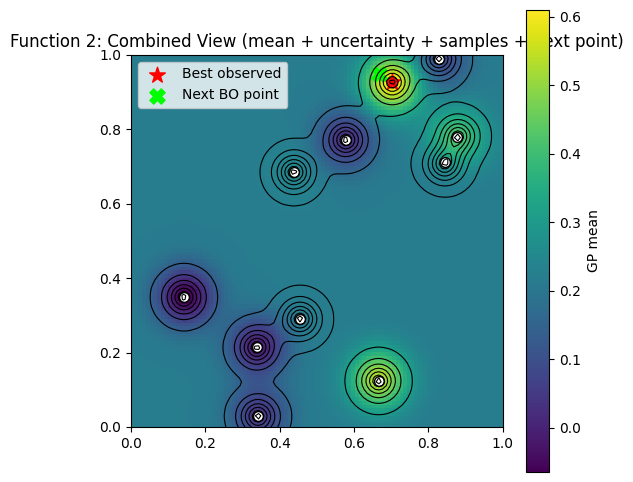

In [27]:
plt.figure(figsize=(6,6))
plt.imshow(mu, origin='lower', extent=(0,1,0,1), aspect='equal', cmap='viridis')
plt.colorbar(label="GP mean")
plt.contour(Xg, Yg, sigma, colors='black', linewidths=0.8)
plt.scatter(inputs_f2[:,0], inputs_f2[:,1], c='white', s=50, edgecolors='black')
plt.scatter(x_best[0], x_best[1], c='red', s=140, marker='*', label='Best observed')
plt.scatter(x_next[0], x_next[1], c='lime', s=120, marker='X', label='Next BO point')
plt.title("Function 2: Combined View (mean + uncertainty + samples + next point)")
plt.legend()
plt.show()